Reading CSV...


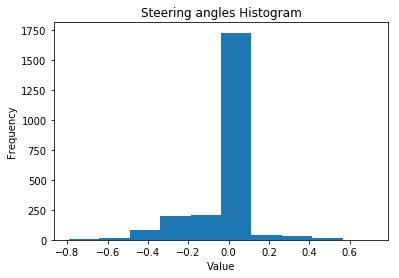

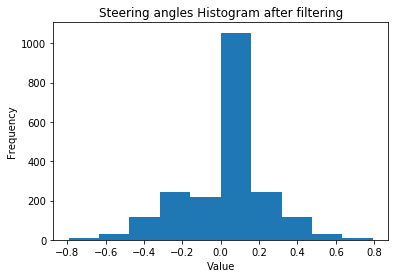

Amount of data items:6216
Amount of train items:4968
Amount of validation items:1248
Reading output values and images...
Training NN...
Epoch 1/2
155/155 [==============================] - 490s - loss: 0.2318 - val_loss: 0.1918
Epoch 2/2
155/155 [==============================] - 441s - loss: 0.1690 - val_loss: 0.1517


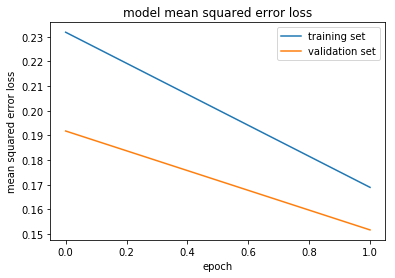

Using the 3 cameras, duplicated with mirroring, gray scale and 66 by 320 size images
Trained model saved...


In [27]:
# modules import section
import csv
import cv2
import sklearn
from random import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam

# import data
# data buffers
input_images = []
samples = []
samples_buffer= []
output_values = []
base_path = './data/'
data_file_csv = open(base_path + 'driving_log.csv')
data_reader = csv.reader(data_file_csv)
first_line = True
factor_for_pre_process = 6 #Get 3 images per line and flipped version = 6 images per CSV line
# read csv file
print('Reading CSV...')
for line in data_reader:
    if first_line:
        first_line = False
    else:
        samples_buffer.append(line)

output_values_steering = []
for sample in samples_buffer:
    output_values_steering.append(float(sample[3]))

# Plot distribution of samples steering initial angles
plt.hist(output_values_steering)
plt.title("Steering angles Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.gcf()
plt.show()

# Filter center values to reduce their frequency
output_values_steering = []
center_counter1 = 0
for sample in samples_buffer:
    center_value = float(sample[3])
    if center_value < 0.00 or center_value > 0.2:
        output_values_steering.append(center_value)
        samples.append(sample)
    if center_value >= 0.00 and center_value <= 0.2:
        if center_counter1 >= 4:
            output_values_steering.append(center_value)
            samples.append(sample)
            center_counter1 = 0
        center_counter1 += 1

output_values_steering_buffer = []
for sample in output_values_steering:
    output_values_steering_buffer.append(-sample)
    output_values_steering_buffer.append(sample)
        
        

# Plot distribution of samples steering initial angles after prefiltering central angle samples
plt.hist(output_values_steering_buffer)
plt.title("Steering angles Histogram after filtering")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.gcf()
plt.show()

output_values_steering_buffer = []


print('Amount of data items:' + str(len(samples) * factor_for_pre_process))

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
total_train_samples = len(train_samples)
total_validation_samples = len(validation_samples)
print('Amount of train items:' + str(total_train_samples * factor_for_pre_process))
print('Amount of validation items:' + str(total_validation_samples * factor_for_pre_process))

# read images and output values
print('Reading output values and images...')

# Correction for perspective of different camaras frmo different angles
steering_correction = 0.2
cropped_height = 66
cropped_width = 200
batch_size = 32

def format_image(img):
    # crop to 66*320*3
    ret_img = img[70:70 + cropped_height,:,:]
    # apply little blur
    ret_img = cv2.GaussianBlur(ret_img, (3,3), 0)
    # scale to 66x200x3
    ret_img = cv2.resize(ret_img,(200, 66), interpolation = cv2.INTER_AREA)
    # convert to YUV color space
    return  cv2.cvtColor(ret_img, cv2.COLOR_BGR2YUV)

# Generator to process data on demand and be able to process large amount of samples
def generator(samples, batch_size=batch_size):
    num_samples = len(samples)
    counter = 0
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            input_images = []
            output_values = []
            for batch_sample in batch_samples:
                for i in range(3):
                    image_file_name = batch_sample[i]
                    image_full_filename = image_file_name.split('/')[-1]
                    image_path = base_path + 'IMG/' + image_full_filename
                    image = cv2.imread(image_path)
                    input_images.append(image)

                output_value_steering = float(batch_sample[3])
                output_value_steering_left = output_value_steering + steering_correction
                output_value_steering_right = output_value_steering - steering_correction
                output_values.append(output_value_steering)
                output_values.append(output_value_steering_left)
                output_values.append(output_value_steering_right)

            aug_input_images = []
            aug_output_values = []
            
            for input_image, output_value in zip(input_images, output_values):
                aug_input_images.append(input_image)
                aug_output_values.append(output_value)
                aug_input_images.append(cv2.flip(input_image, 1))
                aug_output_values.append(-1.0 * output_value)
                
            # Free memory
            input_images = []
            output_values = []
            
            X_train_data = np.zeros((len(aug_input_images), cropped_height, cropped_width, 3))
            counter = 0
            for aug_input_image in aug_input_images:
                X_train_data[counter] =  format_image(aug_input_image)
                counter += 1

            # convert to np arrays
            y_train_data = np.array(aug_output_values)

            # Free memory
            aug_input_images = []
            aug_output_values = []
            yield sklearn.utils.shuffle(X_train_data, y_train_data)
           
        

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

reg_factor = 0.0005
num_epochs = 2

#create a LeNet covnet with keras
model = Sequential()
# Normalize
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(cropped_height, cropped_width, 3)))

# Add 3 * 5x5 convolution layers (output depth 24, 36, and 48), each with 2x2 stride
model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(reg_factor), activation="relu"))
model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(reg_factor), activation="relu"))
model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid', kernel_regularizer=l2(reg_factor), activation="relu"))

# Add 2 * 3x3 convolution layers (output depth 64, and 64)
model.add(Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(reg_factor), activation="relu"))
model.add(Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(reg_factor), activation="relu"))

# Add a flatten layer
model.add(Flatten())
# 4 Fully connected layers of 100, 50, 10 and 1
model.add(Dense(100, kernel_regularizer=l2(reg_factor), activation="relu"))
model.add(Dense(50, kernel_regularizer=l2(reg_factor), activation="relu"))
model.add(Dense(10, kernel_regularizer=l2(reg_factor), activation="relu"))
model.add(Dense(1))

# Train covnet
print('Training NN...')
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
fit_history = model.fit_generator(train_generator, 
                                  steps_per_epoch=int(total_train_samples / batch_size * factor_for_pre_process), 
                                  validation_data=validation_generator,
                                  validation_steps=int(total_validation_samples / batch_size * factor_for_pre_process), 
                                  epochs=num_epochs, verbose=1)

# Plot cost history
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Save model to be used later by drive.py
model.save('model.h5')
print("Using the 3 cameras, duplicated with mirroring, gray scale and 66 by 320 size images")
print('Trained model saved...')
